In [1]:
import collections
import itertools
import json
import pathlib

from jax import tree_util
import matplotlib
from matplotlib import pyplot as plt
import ml_collections
import numpy as np
import pandas as pd
import torch

import hier
import infer
import main
import metrics
import progmet

In [2]:
device = torch.device('cuda')

In [3]:
import configs.inaturalist2021mini

base_config = configs.inaturalist2021mini.get_config()
base_config.dataset_root = '/home/jack/data/manual/inaturalist2021/'

_, eval_dataset, tree, _, _, eval_label_map = main.make_datasets(base_config)

In [4]:
eval_loader = torch.utils.data.DataLoader(
    dataset=eval_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=8)

In [5]:
is_leaf = tree.leaf_mask()
specificity = -tree.num_leaf_descendants()
not_trivial = (tree.num_children() != 1)
subtract_children_fn = hier_torch.SubtractChildren(tree)

In [6]:
infer_fns = {
    'leaf': lambda p: infer.argmax_where(p, is_leaf),
    'majority': lambda p: infer.argmax_with_confidence(specificity, p, 0.5, not_trivial),
    'exclusive': lambda p: np.argmax(subtract_children_fn(torch.from_numpy(p)).numpy(), axis=-1),
}

In [7]:
info_metric = metrics.UniformLeafInfoMetric(tree)
depth_metric = metrics.DepthMetric(tree)

metric_fns = {
    'exact': lambda gt, pr: pr == gt,
    'correct': metrics.IsCorrect(tree),
    'info_excess': info_metric.excess,
    'info_deficient': info_metric.deficient,
    'info_dist': info_metric.dist,
    'info_recall': info_metric.recall,
    'info_precision': info_metric.precision,
    'depth_excess': depth_metric.excess,
    'depth_deficient': depth_metric.deficient,
    'depth_dist': depth_metric.dist,
    'depth_recall': depth_metric.recall,
    'depth_precision': depth_metric.precision,
}

In [8]:
Experiment = collections.namedtuple('Experiment', ['config_file', 'model_file'])

def standard_experiment(experiment_dir, epoch):
    return Experiment(
        config_file=pathlib.Path(experiment_dir) / 'config.json',
        model_file=pathlib.Path(experiment_dir) / f'checkpoints/epoch-{epoch:04d}.pth',
    )

In [9]:
results = {}

In [11]:
experiments = {
    'flat': standard_experiment(
        experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/flat_softmax-lr-0.01-b-64-wd-0.0003-ep-20/',
        epoch=20),
    'hier': standard_experiment(
        experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/hier_softmax-lr-0.01-b-64-wd-0.0003-ep-20/',
        epoch=20),
    'descendant': standard_experiment(
        experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/descendant_softmax-bal-lr-0.01-b-64-wd-0.0003-ep-20/',
        epoch=20),
#     'sibling': standard_experiment(
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/descendant_softmax_complement-bal-lr-0.01-b-64-wd-0.0003-ep-20/',
#         epoch=20),
#     'levelwise': standard_experiment(
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/levelwise_softmax-sum-lr-0.01-b-64-wd-0.0003-ep-20/',
#         epoch=20),
#     'focal': standard_experiment(
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/multilabel_focal-0.95-2-lr-0.01-b-64-wd-0.0003-ep-20/',
#         epoch=20),
#     'focal': standard_experiment(
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/multilabel_focal-0.25-2-lr-0.01-b-64-wd-0.0003-ep-20/',
#         epoch=20),
#     'margin_dist': standard_experiment(
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/soft_margin-lr-0.01-b-64-wd-0.0003-ep-20/',
#         epoch=20),
    'margin_incorrect': standard_experiment(
        experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/soft_margin-incorrect-lr-0.01-b-64-wd-0.0003-ep-20/',
        epoch=20),
    'margin_incorrect_x5': standard_experiment(
        experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/soft_margin-incorrect-5-lr-0.01-b-64-wd-0.0003-ep-20/',
        epoch=20),
    'margin_incorrect_x10': standard_experiment(
        experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/soft_margin-incorrect-10-lr-0.01-b-64-wd-0.0003-ep-20/',
        epoch=20),
    'margin_incorrect_x20': standard_experiment(
        experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/soft_margin-incorrect-20-lr-0.01-b-64-wd-0.0003-ep-20/',
        epoch=20),
#     'margin_dist_fn': standard_experiment(
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/soft_margin-depth_deficient-lr-0.01-b-64-wd-0.0003-ep-20/',
#         epoch=20),
}

In [12]:
markers = {
    'leaf': 'x',
    'majority': 's',
    'exclusive': 'd',
}

colors = dict(zip(
    experiments,
    map(matplotlib.cm.get_cmap('tab10'), itertools.count())))

In [13]:
def apply_model(net, pred_fn, min_threshold):
    # Per-example predictions.

    outputs = {
        'gt': [],  # Node in hierarchy.
        'pred': {method: [] for method in infer_fns},
    }
    # Sequence-per-example predictions. Cannot be concatenated due to ragged shape.
    seq_outputs = {
        'pred': [],
        'prob': [],
    }

    net.eval()
    with torch.inference_mode():
        meter = progmet.ProgressMeter('apply', interval_time=5)
        for minibatch in itertools.islice(meter(eval_loader), None):
            inputs, gt_labels = minibatch
            theta = net(inputs.to(device))
            prob = pred_fn(theta).cpu().numpy()
            pred = {}
            for name, infer_fn in infer_fns.items():
                pred[name] = infer_fn(prob)
            gt_node = eval_label_map.to_node[gt_labels]
            pred_seqs = [
                infer.pareto_optimal_predictions(specificity, p, min_threshold, not_trivial)
                for p in prob
            ]
            prob_seqs = [prob[i, pred_i] for i, pred_i in enumerate(pred_seqs)]
            # Caution: Predictions are *not* truncated.

            outputs['gt'].append(gt_node)
            for method in infer_fns:
                outputs['pred'][method].append(pred[method])
            seq_outputs['pred'].extend(pred_seqs)
            seq_outputs['prob'].extend(prob_seqs)

    # Concatenate results from minibatches.
    leaf_predicate = lambda x: not isinstance(x, dict)  # Treat lists as values, not containers.
    outputs = tree_util.tree_map(np.concatenate, outputs, is_leaf=leaf_predicate)

    return outputs, seq_outputs

In [14]:
def assess_predictions(outputs, seq_outputs):
    gt = outputs['gt']
    pred = outputs['pred']
    pred_seq = seq_outputs['pred']
    prob_seq = seq_outputs['prob']

    # Evaluate predictions for each method.
    pred = {
        method: hier.truncate_at_lca(tree, gt, pr)
        for method, pr in pred.items()
    }
    pred_metrics = {
        method: {field: np.mean(metric_fn(gt, pr))
                 for field, metric_fn in metric_fns.items()}
        for method, pr in pred.items()
    }

    # Evaluate predictions in Pareto sequence.
    find_lca = hier.FindLCA(tree)
    specificity_seq = [specificity[pr_i] for pr_i in pred_seq]
    pred_seq = [hier.truncate_given_lca(gt_i, pr_i, find_lca(gt_i, pr_i)) for gt_i, pr_i in zip(gt, pred_seq)]
    metric_values_seq = {
        field: [metric_fn(gt_i, pr_i) for gt_i, pr_i in zip(gt, pred_seq)]
        for field, metric_fn in metric_fns.items()
    }
    pareto_scores, pareto_totals = metrics.operating_curve(prob_seq, metric_values_seq)
#     specificity_seq = [np.flip(seq) for seq in specificity_seq]
#     metric_values_seq = {field: np.flip(seq) for field, seq in metric_values_seq.items()}
#     pareto_scores, pareto_totals = metrics.operating_curve(specificity_seq, metric_values_seq)
    pareto_means = {k: v / len(gt) for k, v in pareto_totals.items()}

    return pred_metrics, pareto_scores, pareto_means

In [15]:
MIN_THRESHOLD = 0.1  # Values less than 0.5 may increase runtime significantly.

for name, (config_file, model_file) in experiments.items():
    if name in results:
        print('cached:', name)
        continue

    # Load model.
    with open(config_file, 'r') as f:
        config = ml_collections.ConfigDict(json.load(f))
    num_outputs = main.get_num_outputs(config.predict, tree)
    net = main.make_model(config.model, num_outputs)
    missing_keys, unexpected_keys = net.load_state_dict(torch.load(model_file), strict=True)
    assert not missing_keys
    assert not unexpected_keys

    net.to(device)
    _, pred_fn = main.make_loss(config, tree, device)
    outputs, seq_outputs = apply_model(net, pred_fn, min_threshold=MIN_THRESHOLD)
    pred_metrics, pareto_scores, pareto_metrics = assess_predictions(outputs, seq_outputs)
    results[name] = {
        'pred_metrics': pred_metrics,
        'pareto_scores': pareto_scores,
        'pareto_metrics': pareto_metrics,
    }

apply:   2% (6/391); T=0.841 f=1.19; mean T=0.841 f=1.19; elapsed 0:00:05; remaining 0:05:24 of 0:05:29
apply:   5% (18/391); T=0.429 f=2.33; mean T=0.566 f=1.77; elapsed 0:00:10; remaining 0:03:31 of 0:03:41
apply:   8% (30/391); T=0.431 f=2.32; mean T=0.512 f=1.95; elapsed 0:00:15; remaining 0:03:05 of 0:03:20
apply:  11% (42/391); T=0.422 f=2.37; mean T=0.486 f=2.06; elapsed 0:00:20; remaining 0:02:50 of 0:03:10
apply:  14% (54/391); T=0.427 f=2.34; mean T=0.473 f=2.11; elapsed 0:00:26; remaining 0:02:39 of 0:03:05
apply:  17% (66/391); T=0.418 f=2.39; mean T=0.463 f=2.16; elapsed 0:00:31; remaining 0:02:31 of 0:03:01
apply:  20% (78/391); T=0.433 f=2.31; mean T=0.458 f=2.18; elapsed 0:00:36; remaining 0:02:23 of 0:02:59
apply:  23% (90/391); T=0.420 f=2.38; mean T=0.453 f=2.21; elapsed 0:00:41; remaining 0:02:16 of 0:02:57
apply:  26% (102/391); T=0.423 f=2.36; mean T=0.450 f=2.22; elapsed 0:00:46; remaining 0:02:10 of 0:02:56
apply:  29% (114/391); T=0.430 f=2.33; mean T=0.448 f=2

apply:  36% (139/391); T=0.479 f=2.09; mean T=0.486 f=2.06; elapsed 0:01:08; remaining 0:02:02 of 0:03:10
apply:  38% (150/391); T=0.469 f=2.13; mean T=0.485 f=2.06; elapsed 0:01:13; remaining 0:01:57 of 0:03:10
apply:  41% (161/391); T=0.472 f=2.12; mean T=0.484 f=2.07; elapsed 0:01:18; remaining 0:01:51 of 0:03:09
apply:  44% (172/391); T=0.469 f=2.13; mean T=0.483 f=2.07; elapsed 0:01:23; remaining 0:01:46 of 0:03:09
apply:  47% (183/391); T=0.478 f=2.09; mean T=0.483 f=2.07; elapsed 0:01:28; remaining 0:01:40 of 0:03:09
apply:  50% (194/391); T=0.472 f=2.12; mean T=0.482 f=2.07; elapsed 0:01:34; remaining 0:01:35 of 0:03:08
apply:  52% (205/391); T=0.463 f=2.16; mean T=0.481 f=2.08; elapsed 0:01:39; remaining 0:01:29 of 0:03:08
apply:  55% (216/391); T=0.481 f=2.08; mean T=0.481 f=2.08; elapsed 0:01:44; remaining 0:01:24 of 0:03:08
apply:  58% (227/391); T=0.481 f=2.08; mean T=0.481 f=2.08; elapsed 0:01:49; remaining 0:01:19 of 0:03:08
apply:  61% (238/391); T=0.478 f=2.09; mean T=

apply:  54% (213/391); T=0.492 f=2.03; mean T=0.498 f=2.01; elapsed 0:01:46; remaining 0:01:29 of 0:03:15
apply:  57% (224/391); T=0.468 f=2.14; mean T=0.497 f=2.01; elapsed 0:01:51; remaining 0:01:23 of 0:03:14
apply:  60% (235/391); T=0.497 f=2.01; mean T=0.497 f=2.01; elapsed 0:01:57; remaining 0:01:18 of 0:03:14
apply:  63% (246/391); T=0.497 f=2.01; mean T=0.497 f=2.01; elapsed 0:02:02; remaining 0:01:12 of 0:03:14
apply:  66% (257/391); T=0.481 f=2.08; mean T=0.496 f=2.02; elapsed 0:02:08; remaining 0:01:06 of 0:03:14
apply:  69% (268/391); T=0.481 f=2.08; mean T=0.496 f=2.02; elapsed 0:02:13; remaining 0:01:01 of 0:03:14
apply:  71% (279/391); T=0.476 f=2.10; mean T=0.495 f=2.02; elapsed 0:02:18; remaining 0:00:55 of 0:03:13
apply:  74% (290/391); T=0.499 f=2.01; mean T=0.495 f=2.02; elapsed 0:02:24; remaining 0:00:50 of 0:03:14
apply:  77% (301/391); T=0.482 f=2.07; mean T=0.494 f=2.02; elapsed 0:02:29; remaining 0:00:45 of 0:03:13
apply:  80% (312/391); T=0.477 f=2.10; mean T=

apply:  72% (280/391); T=0.485 f=2.06; mean T=0.492 f=2.03; elapsed 0:02:18; remaining 0:00:55 of 0:03:12
apply:  74% (291/391); T=0.485 f=2.06; mean T=0.492 f=2.03; elapsed 0:02:23; remaining 0:00:49 of 0:03:12
apply:  77% (302/391); T=0.484 f=2.06; mean T=0.492 f=2.03; elapsed 0:02:28; remaining 0:00:44 of 0:03:12
apply:  80% (313/391); T=0.471 f=2.12; mean T=0.491 f=2.04; elapsed 0:02:34; remaining 0:00:38 of 0:03:12
apply:  83% (324/391); T=0.473 f=2.11; mean T=0.490 f=2.04; elapsed 0:02:39; remaining 0:00:33 of 0:03:12
apply:  86% (335/391); T=0.480 f=2.08; mean T=0.490 f=2.04; elapsed 0:02:44; remaining 0:00:27 of 0:03:12
apply:  88% (345/391); T=0.503 f=1.99; mean T=0.490 f=2.04; elapsed 0:02:49; remaining 0:00:23 of 0:03:12
apply:  91% (356/391); T=0.482 f=2.07; mean T=0.490 f=2.04; elapsed 0:02:54; remaining 0:00:17 of 0:03:12
apply:  94% (367/391); T=0.472 f=2.12; mean T=0.490 f=2.04; elapsed 0:03:00; remaining 0:00:12 of 0:03:11
apply:  97% (378/391); T=0.472 f=2.12; mean T=

In [16]:
INTEGRALS = [
    ('depth_recall', 'correct'),
    ('depth_recall', 'depth_precision'),
    ('info_recall', 'info_precision'),
    ('exact', 'correct'),
]

auc = {
    f'∫ {y} d({x})': {
        name: metrics.pareto_integrate(
            results[name]['pareto_metrics'][x],
            results[name]['pareto_metrics'][y])
        for name in results
    } for x, y in INTEGRALS
}

pd.DataFrame(auc)

,∫ correct d(depth_recall),∫ depth_precision d(depth_recall),∫ info_precision d(info_recall),∫ correct d(exact)
flat,0.738390,0.757731,0.668889,0.442559
hier,0.684512,0.714619,0.601540,0.311946
descendant,0.722422,0.746699,0.654524,0.384719
margin_incorrect,0.743566,0.761186,0.675089,0.460877
margin_incorrect_x5,0.743843,0.759907,0.676220,0.479718
margin_incorrect_x10,0.732197,0.749600,0.663783,0.467616
margin_incorrect_x20,0.716942,0.736273,0.646439,0.448651


In [17]:
INTERCEPTS = [
    'depth_recall',
    'info_recall',
    'exact',
]

CORRECT = 0.9

recalls = {
    f'{y} @ {CORRECT} correct': {
        name: metrics.pareto_intercept(
            results[name]['pareto_metrics']['correct'],
            results[name]['pareto_metrics'][y],
            CORRECT)
        for name in results
    } for y in INTERCEPTS
}

pd.DataFrame(recalls)

,depth_recall @ 0.9 correct,info_recall @ 0.9 correct,exact @ 0.9 correct
flat,0.653613,0.525989,0.27520
hier,0.576861,0.420647,0.09922
descendant,0.611959,0.477768,0.11525
margin_incorrect,0.665567,0.546302,0.31342
margin_incorrect_x5,0.673141,0.564950,0.36492
margin_incorrect_x10,0.658747,0.551408,0.36152
margin_incorrect_x20,0.638339,0.528213,0.34382


In [18]:
def plot_metrics(x, y, threshold=0.5):
    for name in results:
        pred_metrics = results[name]['pred_metrics']
        pareto_scores = results[name]['pareto_scores']
        pareto_metrics = results[name]['pareto_metrics']
        ge = np.concatenate(([True], pareto_scores >= threshold))
        le = np.concatenate(([False], pareto_scores <= threshold))
        plt.plot(pareto_metrics[x][ge], pareto_metrics[y][ge],
                 color=colors[name], label=name)
        plt.plot(pareto_metrics[x][le], pareto_metrics[y][le],
                 color=colors[name], alpha=0.5)  # linestyle=':')
        for method, method_metrics in pred_metrics.items():
            plt.plot(method_metrics[x], method_metrics[y], color=colors[name],
                     marker=markers[method], markerfacecolor='none')
    plt.ylim(top=1)
    plt.xlim(left=0)
    # plt.axis('equal')
    # plt.gca().set_aspect(1)
    plt.grid()
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()

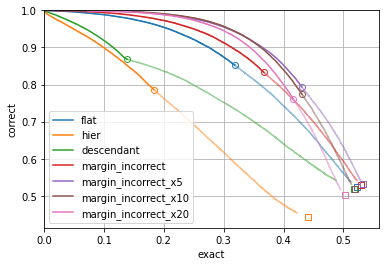

In [19]:
plot_metrics('exact', 'correct')

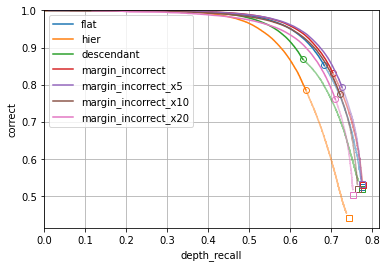

In [20]:
plot_metrics('depth_recall', 'correct')

In [ ]:
plot_metrics('info_recall', 'correct')

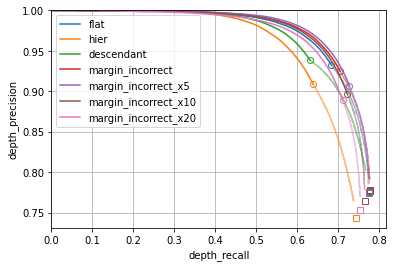

In [21]:
plot_metrics('depth_recall', 'depth_precision')

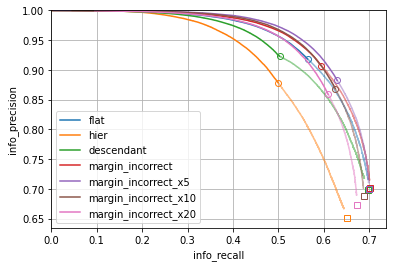

In [22]:
plot_metrics('info_recall', 'info_precision')